In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
from collections import OrderedDict
import numpy as np
import pandas as pd

from sklearn import decomposition, metrics, random_projection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier

import enrichr
import evaluations

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

In [3]:
libs_x = [
    'ChEA_2016', 'ENCODE_TF_ChIP-seq_2015',
    'TRANSFAC_and_JASPAR_PWMs', 'Genome_Browser_PWMs',
    'KEA_2015',
    'GO_Biological_Process_2018', 'GO_Cellular_Component_2018',
    'MGI_Mammalian_Phenotype_2017', 'Human_Phenotype_Ontology',
    'dbGaP', 
    'Genes_Associated_with_NIH_Grants',
    'Chromosome_Location_hg19',
    'Pfam_InterPro_Domains',
    'HomoloGene'    
]
# Parse all gmts 
d_gmt = OrderedDict()
for lib_name in libs_x:
    fp = enrichr.get_library_filepath(lib_name)
    d_gmt_i = enrichr.parse_gmt(fp, namespace=lib_name)
    d_gmt.update(d_gmt_i)

print('Number of gene sets:', len(d_gmt))

Number of gene sets: 48969


In [4]:
# term-frequency matrix (gene sets x genes)
tf_mat, genes_w2v = enrichr.gmt2mat(d_gmt, sparse_output=True, min_frequency=0)
tf_mat.shape

(48969, 62650)

In [5]:
cutoff = 10
mask = np.asarray(tf_mat.sum(axis=0)).reshape(-1) > cutoff
tf_mat = tf_mat[:, mask]

genes_w2v = genes_w2v[mask]
print(tf_mat.shape, genes_w2v.shape)

(48969, 30332) (30332,)


In [6]:
type(tf_mat)

scipy.sparse.csr.csr_matrix

In [7]:
from word2vec_unordered import *

In [8]:
n_total_perms = compute_total_combinations(tf_mat)
n_total_perms

6518974630

In [9]:
batch_size = 128
n_total_perms // batch_size

50929489

In [10]:
batch, labels = generate_batch_unorder(tf_mat, 10)
print(batch)

0
[26288 26288 26288 26288 26288 26288 26288 26288 26288 26288]


In [11]:
print(labels)

[[ 5521]
 [ 5791]
 [13615]
 [14725]
 [18051]
 [13373]
 [16275]
 [22552]
 [28483]
 [ 7110]]


In [12]:
w2vu = Word2VecUnorder(batch_size=128, embedding_size=100, 
                       vocabulary_size= tf_mat.shape[1]
                      )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [14]:
w2vu.fit(tf_mat, n_steps=100001, eval_every_n=5000)

Initialized
Average loss at step 0: 3.017545
Average loss at step 5000: 11.046633
Average loss at step 10000: 25.651436
Average loss at step 15000: 28.621135
Average loss at step 20000: 26.508725
Average loss at step 25000: 25.341215
Average loss at step 30000: 23.335924
Average loss at step 35000: 22.713701
Average loss at step 40000: 34.576759
Average loss at step 45000: 40.650648
Average loss at step 50000: 38.221815
Average loss at step 55000: 37.801523
Average loss at step 60000: 51.248283
Average loss at step 65000: 49.369963
Average loss at step 70000: 51.775271
Average loss at step 75000: 48.744650
Average loss at step 80000: 54.586918
Average loss at step 85000: 53.599803
Average loss at step 90000: 59.403278
Average loss at step 95000: 51.446143
Average loss at step 100000: 52.637278


Word2VecUnorder(batch_size=128, embedding_size=100, learning_rate=1.0,
        loss_type='sampled_softmax_loss', n_neg_samples=64,
        optimize='Adagrad', valid_size=None, valid_window=None,
        vocabulary_size=30332)

In [15]:
X_topics = pd.DataFrame(w2vu.final_embeddings, index=genes_w2v)
X_topics.values.min(), X_topics.values.max()

(-0.48232517, 0.49388033)

In [16]:
w2vu.fit(tf_mat, n_steps=1000001, eval_every_n=5000)

Initialized
Average loss at step 0: 3.686594
Average loss at step 5000: 16.777963
Average loss at step 10000: 25.250526
Average loss at step 15000: 28.002460
Average loss at step 20000: 26.805566
Average loss at step 25000: 25.212456
Average loss at step 30000: 22.954593
Average loss at step 35000: 22.631792
Average loss at step 40000: 28.342887
Average loss at step 45000: 26.596044
Average loss at step 50000: 35.444392
Average loss at step 55000: 37.683398
Average loss at step 60000: 40.034729
Average loss at step 65000: 39.793559
Average loss at step 70000: 43.797473
Average loss at step 75000: 45.064843
Average loss at step 80000: 45.872032
Average loss at step 85000: 45.222763
Average loss at step 90000: 50.792656
Average loss at step 95000: 48.441241
Average loss at step 100000: 46.649946
Average loss at step 105000: 44.263686
Average loss at step 110000: 52.432852
Average loss at step 115000: 55.880437
Average loss at step 120000: 54.886264
Average loss at step 125000: 53.447910


Word2VecUnorder(batch_size=128, embedding_size=100, learning_rate=1.0,
        loss_type='sampled_softmax_loss', n_neg_samples=64,
        optimize='Adagrad', valid_size=None, valid_window=None,
        vocabulary_size=30332)

In [17]:
X_topics_1M = pd.DataFrame(w2vu.final_embeddings, index=genes_w2v)
X_topics_1M.values.min(), X_topics_1M.values.max()

(-0.48051634, 0.4941094)

# Evaluations

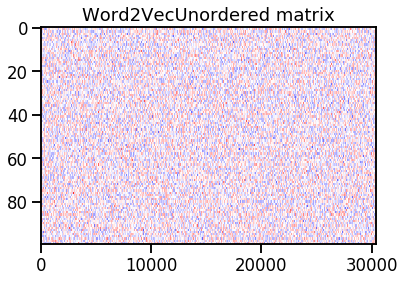

In [18]:
# Visualize W2V
plt.imshow(X_topics.values.T, aspect='auto', cmap='bwr',
          vmin=-0.5, vmax=0.5);
plt.title('Word2VecUnordered matrix');

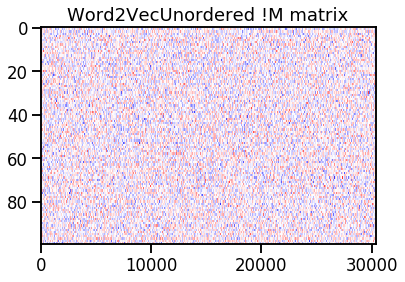

In [19]:
plt.imshow(X_topics_1M.values.T, aspect='auto', cmap='bwr',
          vmin=-0.5, vmax=0.5);
plt.title('Word2VecUnordered !M matrix');

In [20]:
lib_names = [
    'ChEA_2016', 'ENCODE_TF_ChIP-seq_2015', 'ENCODE_Histone_Modifications_2015',
    'TRANSFAC_and_JASPAR_PWMs', 'Genome_Browser_PWMs',
    'KEGG_2016', 'KEA_2015',
    'GO_Biological_Process_2018', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018',
    'MGI_Mammalian_Phenotype_2017', 'Human_Phenotype_Ontology',
    'dbGaP', 
    'Genes_Associated_with_NIH_Grants',
    'Chromosome_Location_hg19',
    'Pfam_InterPro_Domains',
    'HomoloGene'
            ]


In [21]:
# libs used for evaluation
libs_y = ['KEGG_2016', 
          'GO_Molecular_Function_2018',
          'ENCODE_Histone_Modifications_2015']

In [22]:
# Parse all gmts 
d_gmt = {}
for lib_name in lib_names:
    fp = enrichr.get_library_filepath(lib_name)
    d_gmt_i = enrichr.parse_gmt(fp, namespace=lib_name)
    d_gmt.update(d_gmt_i)

print('Number of gene sets:', len(d_gmt))

Number of gene sets: 50825


In [23]:
# term-frequency matrix (gene sets x genes)
tf_mat, genes = enrichr.gmt2mat(d_gmt, sparse_output=True, min_frequency=0)
print(tf_mat.shape)

# TF-IDF normalization
tfidf = TfidfTransformer(norm='l2')
tfidf_mat = tfidf.fit_transform(tf_mat)
print(tfidf_mat.shape)

(50825, 63178)
(50825, 63178)


In [24]:
cutoff = 10
mask = np.asarray(tf_mat.sum(axis=0)).reshape(-1) > cutoff
tf_mat = tf_mat[:, mask]
tfidf_mat = tfidf_mat[:, mask]

genes = genes[mask]
print(tf_mat.shape, genes.shape)

(50825, 32309) (32309,)


In [25]:
# Create a df for terms in gmt
terms_df = pd.DataFrame({
    'library': [ s.split('$')[0] for s in d_gmt.keys()],
    'term': [ s.split('$')[1] for s in d_gmt.keys()],
    'n_genes': [len(val) for val in d_gmt.values()]
}, index=list(d_gmt.keys()))
print(terms_df.shape)

(50825, 3)


In [26]:
mask_lib_x = np.in1d(terms_df['library'], libs_x)
tf_mat_x = tf_mat[mask_lib_x]
tfidf_mat_x = tfidf_mat[mask_lib_x]
print(tf_mat_x.shape, tfidf_mat_x.shape)

(48969, 32309) (48969, 32309)


In [27]:
# Find the overlapping genes
print(len(genes), len(genes_w2v))
shared_genes = list(set(genes) & set(genes_w2v))
print(len(shared_genes))

mask_shared_genes = np.in1d(genes, shared_genes)
tf_mat = tf_mat[:, mask_shared_genes]
shared_genes = genes[mask_shared_genes]

print(len(shared_genes))

32309 30332
30332
30332


In [28]:
X_topics = X_topics.loc[shared_genes]
X_topics.shape

(30332, 100)

In [29]:
X_topics_1M = X_topics_1M.loc[shared_genes]
X_topics_1M.shape

(30332, 100)

In [30]:
knn_scores = evaluations.NN_generalization_accuracy_wrapper(X_topics.values, libs_y, tf_mat.T, 
                                                terms_df['library'],
                                               dummy=True, 
                                               model_name='baseline')

KEGG_2016 (30332, 293)
GO_Molecular_Function_2018 (30332, 1151)
ENCODE_Histone_Modifications_2015 (30332, 412)


In [31]:
knn_scores_w2v = evaluations.NN_generalization_accuracy_wrapper(X_topics.values, libs_y, tf_mat.T, 
                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='W2V')

KEGG_2016 (30332, 293)
GO_Molecular_Function_2018 (30332, 1151)
ENCODE_Histone_Modifications_2015 (30332, 412)


In [32]:
rand_idx = np.arange(X_topics.shape[0])
np.random.shuffle(rand_idx)

knn_scores_w2v_shuffle = evaluations.NN_generalization_accuracy_wrapper(X_topics.values[rand_idx], libs_y, tf_mat.T, 
                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='W2V-shuffle')

KEGG_2016 (30332, 293)
GO_Molecular_Function_2018 (30332, 1151)
ENCODE_Histone_Modifications_2015 (30332, 412)


In [33]:
knn_scores_w2v_1M = evaluations.NN_generalization_accuracy_wrapper(X_topics_1M.values, libs_y, tf_mat.T, 
                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='W2V-1M')

KEGG_2016 (30332, 293)
GO_Molecular_Function_2018 (30332, 1151)
ENCODE_Histone_Modifications_2015 (30332, 412)


In [34]:
# Fit an SVD model
svd = decomposition.TruncatedSVD(n_components=100,
                                random_state=2018)
svd.fit(tfidf_mat_x[:, mask_shared_genes])
X_topics_svd = svd.components_.T # genes by topics matrix
print(X_topics_svd.shape)

(30332, 100)


In [35]:
knn_scores_svd = evaluations.NN_generalization_accuracy_wrapper(X_topics_svd, libs_y, tf_mat.T, 
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='SVD')

KEGG_2016 (30332, 293)
GO_Molecular_Function_2018 (30332, 1151)
ENCODE_Histone_Modifications_2015 (30332, 412)


In [36]:
knn_scores_all = pd.concat([knn_scores, knn_scores_w2v, 
                            knn_scores_w2v_shuffle,
                            knn_scores_w2v_1M,
                            knn_scores_svd, 
                           ])
knn_scores_all.shape

(75, 3)

/Users/maayanlab/Documents/Zichen_Projects/venv3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


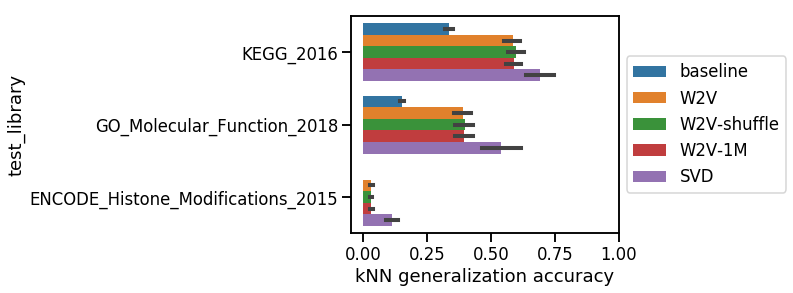

In [37]:
ax = sns.barplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
# ax = sns.swarmplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
ax.set_xlabel('kNN generalization accuracy')
ax.set_xlim([-0.05, 1]);
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));